# Homework 5

## ASTR 5900, Fall 2020, University of Oklahoma

### Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Problem 1

Polymer dielectrics have many applications such as in organic photovoltaics and wearable electronics.  One property that a polymer should have as a dielectric is a high bandgap energy.  There are two compounding difficulties in searching for polymer candidates for these technologies: the volume of chemical space is vast and the evaluation of material properties via *ab initio* methods are computationally expensive.  However it is possible to build a model to  predict the properties of polymers using regression, a supervised learning method.

In this problem we will perform regression on the bandgap energy of certain polymers.  The data is located in `polymers.csv` on canvas.  Featured are 284 unique 4-block materials composed of 7 different molecular building blocks: $CH_2$, $NH$, $CO$, $C_6 H_4$, $C_4 H_2 S$, $CS$, and $O$.  The recorded properties are understood to apply to very long polymers composed of repeated chains of these units.

### Part A

The choice of how data is represented is an important part of machine learning.  One such representation of our molecule data is the $M_{II}$ fingerprint, which is a normalized count of the number of different types of pairs of building blocks in a polyer.  The representation is therefore a $7 \times 7$ matrix with these specifications:

1. The sum of all elements in the matrix should be equal to 4 (since we are dealing with 4-block materials) $$ \sum^7_{i,j} M_{ij} = 4$$
2. The sum of elemnents in any row or column of $M$ should be equal to the total number of blocks of that kind in the polymer.
3. The period symmetry in the polymer dictates that $M$ is a symmetric matrix.  In other words, polymers have the same bandgap energy if they are mirrored.
4. The diagonal elements of $M$ are integers.

Transform the data from `polymers.csv` so that each molecule is represented in the $M_{II}$ fingerprint.

I am providing code to create the dataset as described, but you should convince yourself it is working as intended.

In [2]:
# import csv

# blocks = ['CH2', 'NH', 'CO', 'C6H4', 'C4H2S', 'CS', 'O']

# fingerprints = []
# eps = []
# bgs = []

# with open('polymers.csv', 'r') as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')
#     next(reader, None)
#     for row in reader:
#         poly_str, ep, bg = row[1], row[-2], row[-1]
#         polymer = poly_str.split('-')
#         fingerprint = np.zeros([len(blocks)]*2)
        
#         for i in range(len(polymer)):
#             try:
#                 mol1, mol2 = polymer[i], polymer[i+1]
#             except IndexError:
#                 mol1, mol2 = polymer[i], polymer[0]
                
#             i1, i2 = blocks.index(mol1), blocks.index(mol2)
            
#             fingerprint[i1, i2] += 1
#             fingerprint[i2, i1] += 1
          
#         fingerprints.append(fingerprint/2)
#         eps.append(ep)
#         bgs.append(bg)

# fingerprints = np.array(fingerprints)
# eps = np.array(eps, dtype='float')
# bgs = np.array(bgs, dtype='float')

### Answer:

Here I've transformed the data into fingerprints $M_i$ as described.

In [3]:
fn = './polymers.csv'
dt = [('polymer', 'U23'), ('ep', np.float32), ('bg', np.float32)]
data = np.loadtxt(fn, skiprows=1, usecols=(1, 5, 6), delimiter=',', dtype=dt)
N = len(data)
polymer_size = 4

eps = data['ep']
bgs = data['bg']

blocks = {'CH2': 0, 'NH': 1, 'CO': 2, 'C6H4': 3, 'C4H2S': 4, 'CS': 5, 'O': 6}
n_blocks = len(blocks)

fingerprints = np.empty((N, n_blocks, n_blocks))

for i, poly in enumerate(data['polymer']):
    polymer = poly.split('-')
    fp = np.zeros((n_blocks, n_blocks))
    
    for j in range(polymer_size):
        m1, m2 = polymer[j], polymer[(j + 1) % polymer_size]
        ind = blocks[m1], blocks[m2]
        fp[ind] += 1
    
    fp += fp.T
    fingerprints[i] = fp

fingerprints *= 0.5

In [4]:
print(fingerprints[0])
print(fingerprints[1])

[[0.  0.  0.5 0.  0.  0.5 0. ]
 [0.  0.  0.5 0.  0.  0.5 0. ]
 [0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  0. ]]


Looking at a couple of the fingerprints, they seem to work as intended, abiding by those properties.

### Part B

Perform Kernel Ridge Regression on the data using `sklearn.kernel_ridge.KernelRidge`.  Use a Gaussian kernel with a width ($\sigma$) of 25.  Use an alpha parameter of $10^{-5}$.

You must define your own Gaussian kernel that goes like $$ k(\vec{x}, \vec{v}) = \exp\left( -\frac{1}{2\sigma^2} || \vec{x} - \vec{v}||^2\right)$$
Read this link on `KernelRidge` objects to understand how to implement it: http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge

Use the first 150 data points to train your model, then the remaining 134 to test it.  Calculate the standard error of the test set.  Plot the model values of the data points against their target values, and color each point according to its membership in the test or training set.  Use appropriate labels.

### Answer:

Using kernel ridge regression, we see that the regression predicts well for low band gap energies, however at high band gap energies it begins to predict too low.

standard error: 0.580


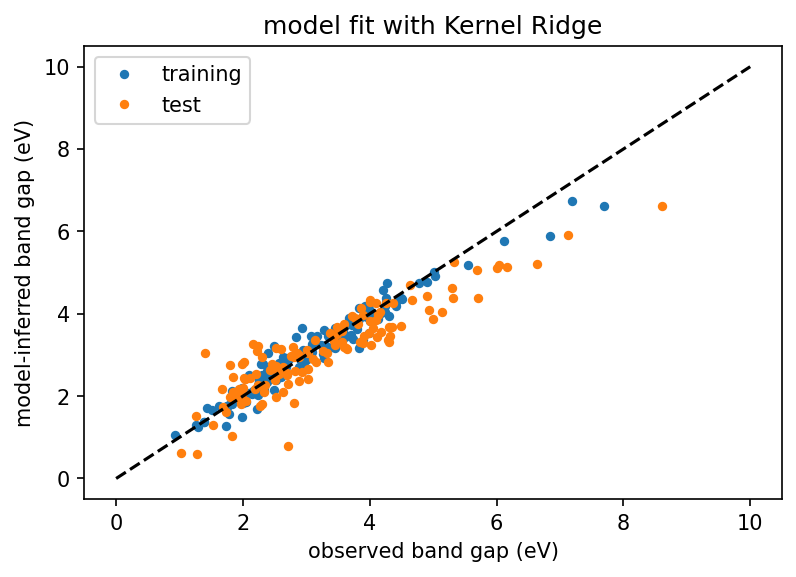

In [5]:
sig = 25.
alpha = 1e-5

# you don't need to define your own RBF since KernelRidge()
# has an 'rbf' option, but here it is anyway:
def my_RBF(X, v, sig=1):
    '''Calculate the RBF kernel function.'''
    arg = - 0.5 * (X - v) @ (X - v) / sig**2
    k = np.exp(arg)
    return k

gamma = 0.5 / sig**2
kr = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)

n_train = 150
kr.fit(fingerprints.reshape(N, n_blocks**2)[:n_train], bgs[:n_train])

y_kr = np.empty(N)
y_kr[:n_train] = kr.predict(fingerprints.reshape(N, n_blocks**2)[:n_train])
y_kr[n_train:] = kr.predict(fingerprints.reshape(N, n_blocks**2)[n_train:])

# I couldn't tell if you meant a proper standard error (sample std of the output set)
# or the RMS around the regression (below), but after calculating the standard
# error it was not descriptive of the larger spread around the estimation/regression
variance = ((bgs[n_train:] - y_kr[n_train:])**2).mean()
print(f'standard error: {np.sqrt(variance):.3f}')

fig, ax = plt.subplots(dpi=150)

ms = 3.5
ax.plot(bgs[:n_train], y_kr[:n_train], 'o', ms=ms, c='tab:blue', label='training')
ax.plot(bgs[n_train:], y_kr[n_train:], 'o', ms=ms, c='tab:orange', label='test')

x_plot = np.linspace(0, 10)
y_plot = np.linspace(0, 10)
ax.plot(x_plot, y_plot, 'k--')

ax.set_xlabel('observed band gap (eV)')
ax.set_ylabel('model-inferred band gap (eV)')
ax.set_title('model fit with Kernel Ridge')

ax.legend()

plt.show()

# Problem 2

Now we will be performing Gaussian Process Regression on the same polymer data from Problem 1.

Use an `sklearn.model_selection.GridSearchCV` object to optimize the hyperparameters of an `sklearn.gaussian_process.GaussianProcessRegressor` object applied to the polymer data.  There are examples on the sci-kit learn website on how to use `GridSearchCV`.  

Use the same split as before to train then test the model.  

Plot the model and true results as in Problem 1, and determine the error.  Comment on your results and compare to Problem 1.  Once trained, what is the error on the training data?  Explain.

### Answer:

We see that by using GPR, the model does not calculate the test output as well, and the uncertainty of the test output around the regression is larger than that from the kernel ridge regression. Therefore, the GPR method may be inferior at prediction. In the final plot, we see from the (observed - predicted) residuals that neither regression performs well at high band gap energies.

Also note that the error around the training set is much smaller. Checking out different values of hyperparameters via `GridSearchCV`, the GPR was able to fit the given set of training data much better, although the test set did not follow the same regression as well.

standard error (test): 0.904
standard error (training): 0.294


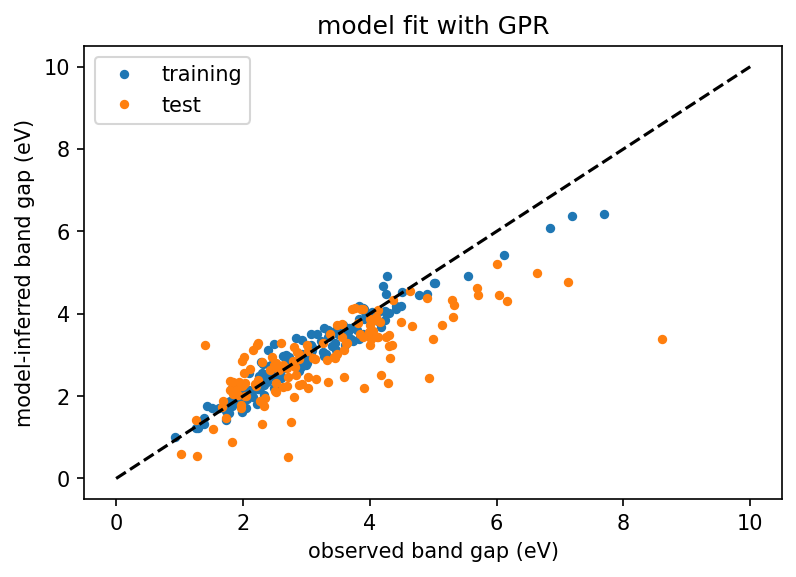

In [6]:
param_grid = {'alpha': np.logspace(0, -3, 4),
              'kernel': [RBF(l) for l in np.logspace(-2, 2, 10)]}
gp = GridSearchCV(GaussianProcessRegressor(), param_grid=param_grid, verbose=0)
gp.fit(fingerprints.reshape(N, n_blocks**2)[:n_train], bgs[:n_train])

y_gp = np.empty(N)
y_gp[:n_train] = gp.predict(fingerprints.reshape(N, n_blocks**2)[:n_train])
y_gp[n_train:] = gp.predict(fingerprints.reshape(N, n_blocks**2)[n_train:])

variance = ((bgs[n_train:] - y_gp[n_train:])**2).mean()
print(f'standard error (test): {np.sqrt(variance):.3f}')

variance = ((bgs[:n_train] - y_gp[:n_train])**2).mean()
print(f'standard error (training): {np.sqrt(variance):.3f}')

fig, ax = plt.subplots(dpi=150)

ms = 3.5
ax.plot(bgs[:n_train], y_gp[:n_train], 'o', ms=ms, c='tab:blue', label='training')
ax.plot(bgs[n_train:], y_gp[n_train:], 'o', ms=ms, c='tab:orange', label='test')

x_plot = np.linspace(0, 10)
y_plot = np.linspace(0, 10)
ax.plot(x_plot, y_plot, 'k--')

ax.set_xlabel('observed band gap (eV)')
ax.set_ylabel('model-inferred band gap (eV)')
ax.set_title('model fit with GPR')

ax.legend()

plt.show()

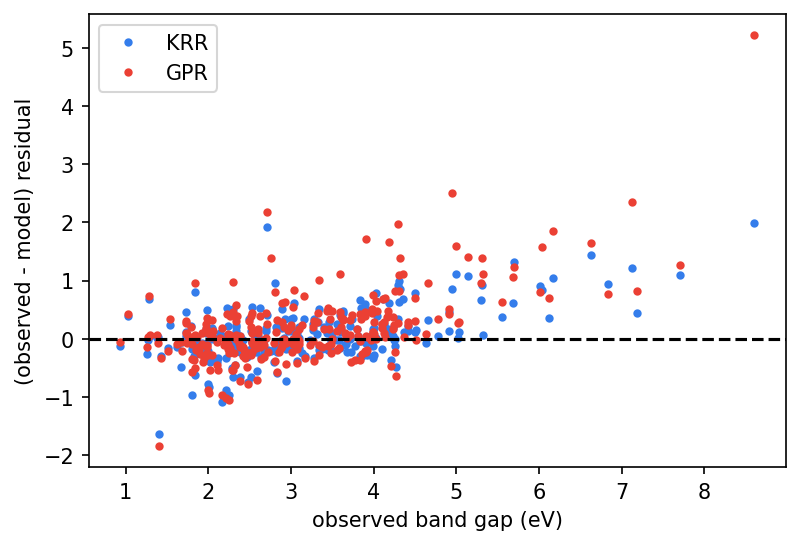

In [7]:
fig, ax = plt.subplots(dpi=150)

res_kr = bgs - y_kr
res_gp = bgs - y_gp

ms = 3
ax.plot(bgs, res_kr, 'o', ms=ms, color='#347deb', label='KRR')
ax.plot(bgs, res_gp, 'o', ms=ms, color='#eb4034', label='GPR')
ax.axhline(0., ls='--', color='k')

ax.set_xlabel('observed band gap (eV)')
ax.set_ylabel('(observed - model) residual')

ax.legend()

plt.show()